# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1HQfIZgHoy4j_RlbmmVjSeUsVVs3P927A

In [2]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [3]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [4]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [5]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [6]:
max_age = np.max(subdf["age"])
min_age = np.min(subdf["age"])
avg_age = np.average(subdf["age"])
print("The maximum age is: ", max_age)
print("The minimum age is: ", min_age)
print("The average age is: ", avg_age)

max_yredu = np.max(subdf["yredu"])
min_yredu = np.min(subdf["yredu"])
avg_yredu = np.average(subdf["yredu"])
print("The maximum yredu is: ", max_yredu)
print("The minimum yredu is: ", min_yredu)
print("The average yredu is: ", avg_yredu)

max_capgain = np.max(subdf["capgain"])
min_capgain = np.min(subdf["capgain"])
avg_capgain = np.average(subdf["capgain"])
print("The maximum capgain is: ", max_capgain)
print("The minimum capgain is: ", min_capgain)
print("The average capgain is: ", avg_capgain)

max_caploss = np.max(subdf["caploss"])
min_caploss = np.min(subdf["caploss"])
avg_caploss = np.average(subdf["caploss"])
print("The maximum caploss is: ", max_caploss)
print("The minimum caploss is: ", min_caploss)
print("The average caploss is: ", avg_caploss)

max_workhr = np.max(subdf["workhr"])
min_workhr = np.min(subdf["workhr"])
avg_workhr = np.average(subdf["workhr"])
print("The maximum workhr is: ", max_workhr)
print("The minimum workhr is: ", min_workhr)
print("The average workhr is: ", avg_workhr)


The maximum age is:  90
The minimum age is:  17
The average age is:  38.58164675532078
The maximum yredu is:  16
The minimum yredu is:  1
The average yredu is:  10.0806793403151
The maximum capgain is:  99999
The minimum capgain is:  0
The average capgain is:  1077.6488437087312
The maximum caploss is:  4356
The minimum caploss is:  0
The average caploss is:  87.303829734959
The maximum workhr is:  99
The minimum workhr is:  1
The average workhr is:  40.437455852092995


In [7]:
# normalize using (x-x_min)/(x_max-x_min)
df["age"] = (df["age"] - min_age)/(max_age-min_age)
df["yredu"] = (df["yredu"] - min_yredu)/(max_yredu-min_yredu)
df["capgain"] = (df["capgain"] - min_capgain)/(max_capgain-min_capgain)
df["caploss"] = (df["caploss"] - min_caploss)/(max_caploss-min_caploss)
df["workhr"] = (df["workhr"] - min_workhr)/(max_workhr-min_workhr)
print(df["age"])

0        0.301370
1        0.452055
2        0.287671
3        0.493151
4        0.150685
           ...   
32556    0.136986
32557    0.315068
32558    0.561644
32559    0.068493
32560    0.479452
Name: age, Length: 32561, dtype: float64


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [65]:
# hint: you can do something like this in pandas
number_of_men = sum(df["sex"] == " Male")
number_of_people = df["sex"].count()
percentage_of_men = number_of_men/number_of_people
print("The male percentage:", percentage_of_men*100, "%")

number_of_women = sum(df["sex"] == " Female")
percentage_of_women = number_of_women/number_of_people
print("The female percentage:", percentage_of_women*100, "%")

The male percentage: 66.92054912318419 %
The female percentage: 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [8]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [9]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print(len(df_with_missing), "rows had missing info")
print((len(df_with_missing)/len(df))*100, "% of records were removed")

1843 rows had missing info
5.660145572924664 % of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [11]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [10]:
data = pd.get_dummies(df_not_missing)

In [23]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [26]:
work_cols = len(set(df_not_missing["work"]))
marriage_cols = len(set(df_not_missing["marriage"]))
occupation_cols = len(set(df_not_missing["occupation"]))
edu_cols = len(set(df_not_missing["edu"]))
relationship_cols = len(set(df_not_missing["relationship"]))
sex_cols = len(set(df_not_missing["sex"]))
print("There are ", data.shape[1], "columns because there are ", 
      work_cols, "possible values for work,", 
      marriage_cols, "possible values for marriage,", 
      occupation_cols, "possible values for occupation,", 
      edu_cols, "possible values for edu,",
      relationship_cols, "possible values for relationship,",
      sex_cols, "possible values for sex, and the 5 columns from before.")

There are  57  columns because there are  7 possible values for work 7 possible values for marriage 14 possible values for occupation 16 possible values for edu 6 possible values for relationship 2 possible values for sex, and the 5 columns from before


There are  57  columns because there are  7 possible values for work 7 possible values for marriage 14 possible values for occupation 16 possible values for edu 6 possible values for relationship 2 possible values for sex, and the 5 columns from before.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [11]:
datanp = data.values.astype(np.float32)

In [12]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

print(cat_index)
print(cat_values)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """

    return cat_values[feature][np.argmax(onehot)]

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [13]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [14]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

all_indices = np.arange(len(data))
np.random.shuffle(all_indices)
seventy_split = int(len(all_indices) * 0.7)
fifteen_split = int(len(all_indices) * 0.85)

train_indices, val_indices, test_indices = all_indices[:seventy_split], all_indices[seventy_split:fifteen_split], all_indices[fifteen_split:]

train_set = datanp[train_indices]
val_set = datanp[val_indices]
test_set = datanp[test_indices]

print("Size of training set:", len(train_set))
print("Size of validation set:", len(val_set))
print("Size of test set:", len(test_set))

Size of training set: 21502
Size of validation set: 4608
Size of test set: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [15]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "autoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 57),
            nn.ReLU(),
            nn.Linear(57, 35),
            nn.ReLU(),
            nn.Linear(35, 20),
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 35),
            nn.Linear(35, 57),
            nn.Linear(57, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

We normalized our values in part one and we have to make sure the output is also normalized. Sigmoid function forces values to be between 0 and 1 so we use it to make the output match the input.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [16]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_model_name(name, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}_epoch{2}".format(name, learning_rate, epoch)
    return path

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            t_loss = criterion(recon, data)
            t_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += t_loss.item()
          
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            v_loss = criterion(recon, data)
            total_val_loss += v_loss.item()
        
        iters.append(epoch)

        train_loss.append(float(total_train_loss)/len(train_loader))         # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy

        print("At epoch", epoch+1, "Training accuracy: ",train_acc[epoch])

        val_loss.append(float(total_val_loss)/len(valid_loader))
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [17]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

At epoch 1 Training accuracy:  0.4482606269184262
At epoch 2 Training accuracy:  0.45910457941896876
At epoch 3 Training accuracy:  0.46217406132762845
At epoch 4 Training accuracy:  0.5360741636436921
At epoch 5 Training accuracy:  0.5515920999596937
At epoch 6 Training accuracy:  0.5593355656838124
At epoch 7 Training accuracy:  0.5674510898211019
At epoch 8 Training accuracy:  0.5698384646389483
At epoch 9 Training accuracy:  0.5743961802002915
At epoch 10 Training accuracy:  0.5833720894180386
At epoch 11 Training accuracy:  0.5872787027563328
At epoch 12 Training accuracy:  0.5852401327008341
At epoch 13 Training accuracy:  0.5881778439214956
At epoch 14 Training accuracy:  0.5877592782066785
At epoch 15 Training accuracy:  0.589131243605246
At epoch 16 Training accuracy:  0.5913558428673301
At epoch 17 Training accuracy:  0.5957197780051469
At epoch 18 Training accuracy:  0.6025796049979847
At epoch 19 Training accuracy:  0.6109431680773881
At epoch 20 Training accuracy:  0.61399

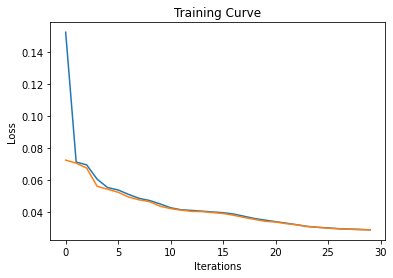

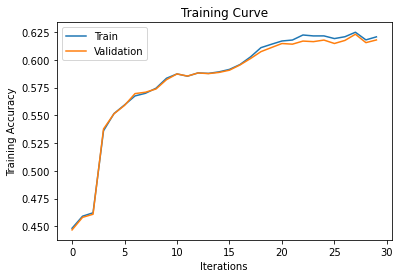

Final Training Accuracy: 0.6206631941214771
Final Validation Accuracy: 0.6178747106481481


In [66]:
autoEncoder = AutoEncoder()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=1)
train(autoEncoder, train_loader, val_loader, 30)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

At epoch 1 Training accuracy:  0.5174324869004434
At epoch 2 Training accuracy:  0.5649319443152575
At epoch 3 Training accuracy:  0.5854339131243605
At epoch 4 Training accuracy:  0.6011766347316528
At epoch 5 Training accuracy:  0.6058583697640529
At epoch 6 Training accuracy:  0.6083000031004868
At epoch 7 Training accuracy:  0.6092534027842371
At epoch 8 Training accuracy:  0.608710817598363
At epoch 9 Training accuracy:  0.6081759836294298
At epoch 10 Training accuracy:  0.6105866120980994
At epoch 11 Training accuracy:  0.61300499178371
At epoch 12 Training accuracy:  0.6088658419371842
At epoch 13 Training accuracy:  0.6185626143304499
At epoch 14 Training accuracy:  0.614950547235916
At epoch 15 Training accuracy:  0.6183688339069234
At epoch 16 Training accuracy:  0.6121058506185472
At epoch 17 Training accuracy:  0.6206941989892413
At epoch 18 Training accuracy:  0.6197020432207857
At epoch 19 Training accuracy:  0.61636901993613
At epoch 20 Training accuracy:  0.623577651691

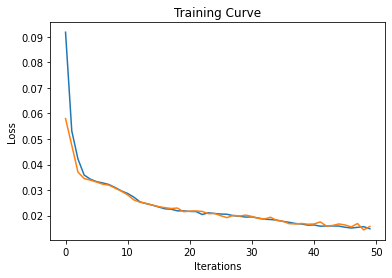

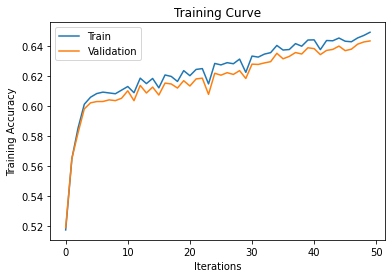

Final Training Accuracy: 0.6491644188137538
Final Validation Accuracy: 0.6433738425925926


In [84]:
autoEncoder = AutoEncoder()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, num_workers=1)
train(autoEncoder, train_loader, val_loader, 50, 0.001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

Initially starting with the default learning rate value of 0.0001, we got a training accuracy of 0.6040600874337271 and a validation accuracy of 0.6017795138888888. Since 0.0001 is a very small number, my first instinct was to increase it by a factor of 10. With the learning rate of 0.001, we go training accuracy of 0.6473971413511921 and validation accuracy of 0.6424334490740741. So I decided to further increase the learning rate and try 0.01. With that the training accuracy and validation accuracy came to 0.6054398040492357 and 0.6021412037037037 respectively which was a lower accuracy compared to lr=0.001. Lastly, I tried a higher batch size of 128 instead of 64 and increased the number of epochs to 50, with the best learning rate of 0.001. The training accuracy ended up being 0.6491644188137538 and the validation accuracy 0.6433738425925926. The best model seems to be batch_size=64, learning_rat=0.001, and num_epochs=50. (Since the accuracy of the last set of hyper params ar 30 epochs was lower with the higher batch_size.)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [85]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, num_workers=1)
test_acc = get_accuracy(autoEncoder, test_loader)
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.6451099537037037


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [49]:
most_common = {}
for cat in catcols:
  most_common[cat] = df[cat].value_counts().idxmax().lstrip()


match = 0
for row in test_set:
    test_values = get_features(row)
    for cat in catcols:
        if most_common[cat] == test_values[cat]:
            match += 1

total = (len(test_set) * len(catcols))
acc = match / total
print("The accuracy of the baseline model is", acc*100 , "%")

The accuracy of the baseline model is 45.68504050925926 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The best accuracy we got with our autoencoder was about 64% whereas with the baseline it about 46%. Out nn accuracy is higher as expected and since it's higher by about 18% we could say that our autoencoder performs well but could also be improved a bit.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [51]:
first_row = get_features(test_set[0])
print(first_row)

{'work': 'Private', 'marriage': 'Divorced', 'occupation': 'Prof-specialty', 'edu': 'Bachelors', 'relationship': 'Not-in-family', 'sex': 'Male'}


No. There's so much that happens in someone's life to get to any of the categories and each person is unique. Also, there are some categories that may be corralated like work and education and occupation and some that may not be like marriage and work.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [60]:
out = autoEncoder(zero_out_feature(torch.tensor(test_set[0]).view(1,57), "edu"))
out = out.detach().numpy()
edu = get_feature(out[0],"edu")
print("Our model predicts that this person's education level is: ", edu)

Our model predicts that this person's education level is:  Doctorate


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [54]:
most_common_edu = df['edu'].value_counts().idxmax().lstrip()
print("The baseline model predicts that this person's education level is:", most_common_edu)

The baseline model predicts that this person's education level is: HS-grad


In [67]:
%%shell
jupyter nbconvert --to html /content/Lab4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook /content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 468573 bytes to /content/Lab4_Data_Imputation.html
